Exotic Derivatives Pricing using MC - Spread Option

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Part A - Antithetical Sampling

Defined the functions simulateS1 and simulateS2 which generate two arrays of paths; size = n .

In [2]:
def simulateS1(S0, mu, v, q, T, n): #parameters for asset 1
    rng = np.random.default_rng()  # set generator PCG64
    Z1 = rng.normal(0.0, 1.0, size=n)  # n standard normal random variables
    Z1_antithetic = -Z1

    ST_original = S0 * np.exp((mu - q - (v ** 2) / 2) * T + v * np.sqrt(T) * Z1)
    ST_antithetic = S0 * np.exp((mu - q - (v ** 2) / 2) * T + v * np.sqrt(T) * Z1_antithetic)

    ST = np.concatenate((ST_original, ST_antithetic))
    return ST

def simulateS2(S0, mu, v, q, T, rho, n): #parameters for asset 2
  rng = np.random.default_rng()  # set generator PCG64
  Z = rng.normal(0.0, 1.0, size=(2, n))  # 2 x n array of standard normal random variables
  Z1, Z2 = Z  # First row for Z1, second row for Z2
  Z1_antithetic, Z2_antithetic = -Z1, -Z2  # Antithetic counterparts

  ST_original = S0 * np.exp((mu - q - (v ** 2) / 2) * T + rho * v * Z1 * np.sqrt(T) + np.sqrt(1 - rho ** 2) * v * Z2 * np.sqrt(T))
  ST_antithetic = S0 * np.exp((mu - q - (v ** 2) / 2) * T + rho * v * Z1_antithetic * np.sqrt(T) + np.sqrt(1 - rho ** 2) * v * Z2_antithetic * np.sqrt(T))

  ST = np.concatenate((ST_original, ST_antithetic))
  return ST

Simulate the payoff of all paths $\max[{S0 - S1 - K, 0}]$ then discount by factor $\exp[{-rT}]$ to PV.  Take the mean of all these and this gives valuation.

In [3]:
def sim_option_price(S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, K, T, rho, r, n): #both paths should have same # of paths so I have only included n (as opposed to n1,n2)
    """Standard Antithetic Sampling"""
    S1 = simulateS1(S0 = S0_1, mu = mu_1, v = v1, q = q1, T = T, n = n)
    S2 = simulateS2(S0 = S0_2, mu = mu_2, v = v2, q = q2, T = T, rho = rho, n = n)
    payoff = np.maximum(S1 - S2 - K, 0)
    disc_payoffs = np.exp(-r * T) * payoff
    sim_price = np.mean(disc_payoffs)
    err_bound = 1.96 * disc_payoffs.std(ddof=1)/np.sqrt(n)
    return [sim_price, err_bound]

The $(1-\alpha)100\%$ Confidence Interval between all the discounted payoffs is easily calculated using the error bound in the function sim_option_price.

In [4]:
conf = sim_option_price(S0_1 = 300, S0_2 = 100, mu_1 = 0.02, mu_2 = 0.03, v1 = 0.10, v2 = 0.15, q1 = 0.0, q2 = 0.0, K = 10, T = 1, rho = 0.80, r = 0.05, n = 100000)
CI = (round(conf[0] - conf[1], 4), round(conf[0] + conf[1], 4))
print(f'95% Confidence Interval : {CI}')

95% Confidence Interval : (183.4052, 183.8115)


## Part A - Msc.

### Distribution of Payoffs

Below is a visualization of the distribution of payoffs for all 2n paths that we have generated in the MC simulation.  We now seek to find a CI for this distribution.

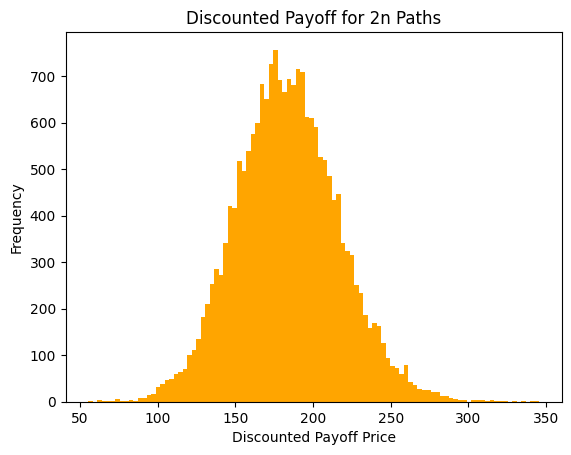

In [5]:
def DiscPayoff(S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, K, T, rho, r, n): #both paths should have same # of paths so I have only included n (as opposed to n1,n2)
    """Standard Antithetic Sampling"""
    S1 = simulateS1(S0 = S0_1, mu = mu_1, v = v1, q = q1, T = T, n = n)
    S2 = simulateS2(S0 = S0_2, mu = mu_2, v = v2, q = q2, T = T, rho = rho, n = n)
    payoff = np.maximum(S1 - S2 - K, 0)
    disc_payoffs = np.exp(-r * T) * payoff
    return disc_payoffs

dist = DiscPayoff(S0_1 = 300, S0_2 = 100, mu_1 = 0.02, mu_2 = 0.03, v1 = 0.10, v2 = 0.15, q1 = 0.0, q2 = 0.0, K = 10, T = 1, rho = 0.80, r = 0.05, n = 10000)
plt.hist(dist,bins = 100, color = 'orange');
plt.title(f'Discounted Payoff for 2n Paths');
plt.xlabel('Discounted Payoff Price');
plt.ylabel('Frequency');

We can also find the distribution of the option prices.

In [6]:
def dist_optionprices(S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, K, T, rho, r, n, N): # Return a array of N prices simulated
    prices = []
    for i in range(N):
        price = sim_option_price(S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, K, T, rho, r, n)
        prices.append(price[0])
    return np.array(prices)

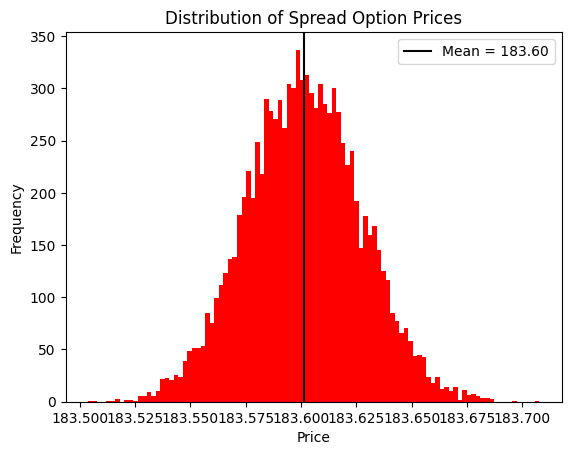

In [7]:
## Function to simulate N option prices (where each option price it the mean of 2n stock paths for S1 and S2 w/ Antithetic Sampling)

def plotdist_optionprices(S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, K, T, rho, r, n, N): # Return a plot
    prices = []
    for i in range(N):
        price = sim_option_price(S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, K, T, rho, r, n)
        prices.append(price[0])

    fig, ax = plt.subplots()
    ax.hist(prices, bins=100, color='red')
    ax.set_title('Distribution of Spread Option Prices')
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')
    ax.axvline(np.mean(prices), color='black', label=f'Mean = {np.mean(prices):.2f}')
    ax.legend()

#Example

plotdist_optionprices(S0_1 = 300, S0_2 = 100, mu_1 = 0.02, mu_2 = 0.03, v1 = 0.10, v2 = 0.15, q1 = 0.0, q2 = 0.0, K = 10, T = 1, rho = 0.80, r = 0.05, n = 10000, N = 10000)

# Part B & C - Adjusted Antithetical Sampling

In [8]:
def simulateS1adj(S01, mu1, v1, q1, T, n): #parameters for asset 1
    rng = np.random.default_rng()  # set generator PCG64
    Z1 = rng.normal(0.0, 1.0, size=2*n)  # 2n standard normal random variables
    Z1_antithetic = -Z1

    ST_original = S01 * np.exp((mu1 - q1 - (v1 ** 2) / 2) * T + v1 * np.sqrt(T) * Z1)
    ST_antithetic = S01 * np.exp((mu1 - q1 - (v1 ** 2) / 2) * T + v1 * np.sqrt(T) * Z1_antithetic)

    ST = np.concatenate((ST_original, ST_antithetic))
    return ST

def simulateS2adj(S02, mu2, v2, q2, T, rho, n):
    rng = np.random.default_rng()  # Random number generator
    Z = rng.normal(0.0, 1.0, size=(2, n))  # Generate (z, w) samples
    Z1, Z2 = Z
    Z1_antithetic = -Z1
    Z2_antithetic = -Z2
    ST1_ = S02 * np.exp((mu2 - q2 - (v2 ** 2) / 2) * T + rho * v2 * Z1 * np.sqrt(T) + np.sqrt(1 - rho ** 2) * v2 * Z2 * np.sqrt(T))
    ST2_ = S02 * np.exp((mu2 - q2 - (v2 ** 2) / 2) * T + rho * v2 * Z1_antithetic * np.sqrt(T) + np.sqrt(1 - rho ** 2) * v2 * Z2 * np.sqrt(T))
    ST3_ = S02 * np.exp((mu2 - q2 - (v2 ** 2) / 2) * T + rho * v2 * Z1 * np.sqrt(T) + np.sqrt(1 - rho ** 2) * v2 * Z2_antithetic * np.sqrt(T))
    ST4_ = S02 * np.exp((mu2 - q2 - (v2 ** 2) / 2) * T + rho * v2 * Z1_antithetic * np.sqrt(T) + np.sqrt(1 - rho ** 2) * v2 * Z2_antithetic * np.sqrt(T))
    ST2 = np.concatenate([ST1_, ST2_, ST3_, ST4_])

    return ST2

In [9]:
def sim_option_priceadj(S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, K, T, rho, r, n): #both paths should have same # of paths so I have only included n (as opposed to n1,n2)
    """Standard Antithetic Sampling"""
    S1 = simulateS1adj(S01 = S0_1, mu1 = mu_1, v1 = v1, q1 = q1, T = T, n = n)
    S2 = simulateS2adj(S02 = S0_2, mu2 = mu_2, v2 = v2, q2 = q2, T = T, rho = rho, n = n)
    payoff = np.maximum(S1 - S2 - K, 0)
    disc_payoffs = np.exp(-r * T) * payoff
    sim_price = np.mean(disc_payoffs)
    err_bound = 1.96 * disc_payoffs.std(ddof=1)/np.sqrt(n)
    sim_price, err_bound
    return [sim_price, err_bound]

Consider the following example:

In [10]:
S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, K, T, rho, r, n = 110, 100, 0.02, 0.03, 0.10, 0.15, 0.0, 0.0, 10, 1, 0.80, 0.05, 10**5

#Adjusted Method Price
price, errorbound = sim_option_priceadj(S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, K, T, rho, r, n)
print(f'price = {round(price,2)}\nerror bound = {round(errorbound,6)}')

price = 6.84
error bound = 0.062239


Now calculating the price of both methods for N simulations and determining if there truly is a variance reduction with the adjusted method.

In [11]:
#Set N
N = 1000

#Loop both methods N times
prices = []
pricesadj = []
for i in range(N):
    price = sim_option_price(S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, K, T, rho, r, n)
    prices.append(price[0])

    priceadj = sim_option_priceadj(S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, K, T, rho, r, n)
    pricesadj.append(priceadj[0])

Visualize both methods.

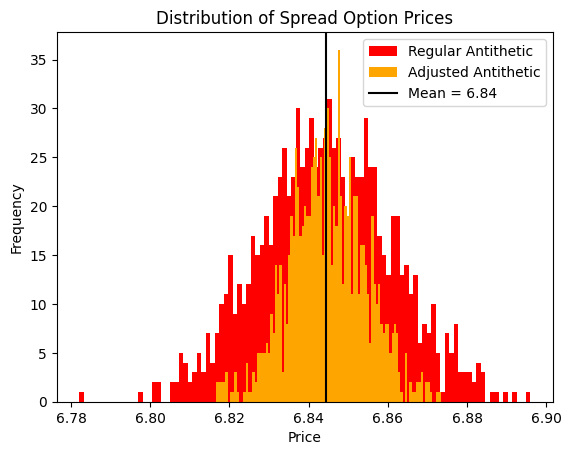

In [12]:
fig, ax = plt.subplots()
ax.hist(prices, bins=100, color='red',label = 'Regular Antithetic',alpha = 1)
ax.hist(pricesadj, bins=100, color='orange', label = 'Adjusted Antithetic', alpha = 1)
ax.set_title('Distribution of Spread Option Prices')
ax.set_xlabel('Price')
ax.set_ylabel('Frequency')
ax.axvline(np.mean(prices), color='black', label=f'Mean = {np.mean(prices):.2f}')
ax.legend()

Clearly, we can see the adjusted antithetic method has a smaller variance and appears to even have a lower kurtosis!  Let us calculate the variance reduction between the two methods, regular antithetical vs adjusted antithetical.

In [13]:
variance_regular = np.var(np.array(prices))
variance_adjusted = np.var(np.array(pricesadj))
print(f'The variance of the regular antithetic sampling method is {variance_regular:4f}.\nThe variance of the adjusted anthithetic sampling method is {variance_adjusted:4f}.')
print(f'Therefore, the adjusted method attains an approximate {100 - round((variance_adjusted/variance_regular)*100,2)}% reduction in variance')

The variance of the regular antithetic sampling method is 0.000279.
The variance of the adjusted anthithetic sampling method is 0.000093.
Therefore, the adjusted method attains an approximate 66.45% reduction in variance


We can conclude that the method of using 4 variates $(Z_1, Z_2), (Z_1, -Z_2), (-Z_1, Z_2), (-Z_1, -Z_2)$ provides significant variance reduction.

# Part D - Relative Error Bound

Ideally, we want to find n such that the error bound is less than 0.1% of the price.

In [14]:
S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, K, T, rho, r = 110, 100, 0.02, 0.03, 0.10, 0.15, 0.0, 0.0, 10, 1, 0.80, 0.05

#Part A Method Price for varying n
n = [10**i for i in range(2,8)]
errorbound_dict = {n_i:[] for n_i in n}
for n_i in n:
  price, errorbound = sim_option_price(S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, K, T, rho, r, n_i)
  errorbound_dict[n_i].extend([price, errorbound])

df = pd.DataFrame(errorbound_dict).T
df = df.reset_index().rename(columns = {'index':'n', 0:'Price', 1:'ErrorBound'})
df['Err/Price'] = df['ErrorBound']/df['Price']
df['Err/Price (%)'] = 100 * df['Err/Price']
df['[n = valid]'] = df['Err/Price (%)'].apply(lambda x: True if x < 0.1 else False)
print(df)

          n     Price  ErrorBound  Err/Price  Err/Price (%)  [n = valid]
0       100  7.118657    1.888819   0.265334      26.533363        False
1      1000  6.853791    0.624355   0.091096       9.109631        False
2     10000  6.896492    0.198448   0.028775       2.877520        False
3    100000  6.817595    0.062057   0.009103       0.910253        False
4   1000000  6.851932    0.019698   0.002875       0.287486        False
5  10000000  6.846443    0.006225   0.000909       0.090917         True


Therefore, for $n = 10000000 = 10^7$ the % error bound relative to the price is less than 0.1%

# Part E - Kirks' Approximation

Below is Kirks' formula for a call option on the spread of two asset prices:


$C_K = e^{-rT} \left[ F_1 N(d_1) - (F_2 + K) N(d_2) \right]$


Where:


$F_1 = S_1(0)e^{\mu_1 T}, \quad F_2 = S_2(0)e^{\mu_2 T}$



$d_1 = \frac{\ln\left(\frac{F_1}{F_2 + K}\right) + \frac{\sigma_K^2 T}{2}}{\sigma_K \sqrt{T}}$



$d_2 = d_1 - \sigma_K \sqrt{T}$



$\sigma_K = \sqrt{\sigma_1^2 - 2 \left(\frac{F_2}{F_2 + K}\right) \rho \sigma_1 \sigma_2 + \left(\frac{F_2}{F_2 + K}\right)^2 \sigma_2^2}$

---

$^1 \text{E. Kirk and J. Aron, Correlation in the energy markets, Managing energy price risk, 1 (1995), pp. 71–78}$




In [15]:
S0_1, S0_2, mu_1, mu_2, v1, v2, K, T, rho, r = 110, 100, 0.02, 0.03, 0.10, 0.15, 10, 1, 0.80, 0.05

def kirk_price(S0_1, S0_2, mu_1, mu_2, v1, v2, K, T, rho, r):
  F1 = S0_1 * np.exp(mu_1*T)
  F2 = S0_2 * np.exp(mu_2*T)
  vK = np.sqrt(v1**2 - 2*(F2/(F2+K))*rho*v1*v2 + ((F2/(F2+K))**2)*(v2**2))
  d1 = (np.log(F1/(F2+K)) + ((vK**2)*T)/2) / (vK * np.sqrt(T))
  d2 = d1 - vK * np.sqrt(T)
  CK = np.exp(-r*T) * (F1*norm.cdf(d1) - (F2+K)*norm.cdf(d2))
  return CK

# Part F & G - Adjust Strikes & Correlation

We will use n from part D and get the price and error bound for varying strikes and correlations.  We will also get the price for these varied parameters.

In [16]:
n_partd = df['n'].loc[df['[n = valid]'] == True].values[0]
K_list = [5*i for i in range(-4,5)]
rho_list = [-1.0, -0.5, 0, 0.4, 0.8, 1.0]

#initialize error dictionary with the keys being a tuple (strike, rho)
error_dict = {}

S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, T, r = 110, 100, 0.02, 0.03, 0.10, 0.15, 0.0, 0.0, 1, 0.05
for k_i in K_list:
  for rho_j in rho_list:
    ptA_price = sim_option_price(S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, k_i, T, rho_j, r, n_partd)
    error_dict[k_i, rho_j] = ptA_price

errorA_df = pd.DataFrame(error_dict).T.rename(columns={0:'ptA Price',1:'ptA ErrorBound'})

In [17]:
ptA_dict_price = {}
ptA_dict_errbound = {}

rho_index_map = {rho: idx for idx, rho in enumerate(rho_list)}

for k_i in K_list:
    for rho_j in rho_list:
        ptA_price = sim_option_price(S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, k_i, T, rho_j, r, n_partd)
        ptA_dict_price[(k_i, rho_j)] = ptA_price[0]
        ptA_dict_errbound[(k_i, rho_j)] = ptA_price[1]

ptA_price_df = pd.DataFrame(index=K_list, columns=rho_list)
ptA_errorbound_df = pd.DataFrame(index=K_list, columns=rho_list)

for (k_i, rho_j), price in ptA_dict_price.items():
    ptA_price_df.loc[k_i, rho_j] = price

for (k_i, rho_j), err_bound in ptA_dict_errbound.items():
    ptA_errorbound_df.loc[k_i, rho_j] = err_bound

Print both of these 2d grids.  The grids are the MC prices for the spread option from part A grid and the error bound from the same MC simulation grid respectively.

In [77]:
print(ptA_price_df)
#price from part A 2d grid; row is strikes and column is rho (correlation)

          -1.0       -0.5        0.0        0.4        0.8        1.0
-20  28.381249  28.380856  28.382159  28.381151  28.381882  28.381219
-15  24.031121   24.02993  24.030944  24.029453  24.031041  24.028982
-10  19.889563  19.888678  19.888832  19.889765  19.888767  19.890096
-5   16.028468  16.029872  16.028537  16.030896  16.029691  16.028881
 0   12.523955  12.522878  12.521852  12.524604   12.52461  12.521402
 5    9.446082   9.446088   9.442796   9.444086    9.44599   9.446518
 10   6.846748   6.845155    6.84529   6.847412   6.842243   6.844271
 15   4.742597   4.746237   4.746161   4.744964   4.744125   4.744601
 20    3.13319    3.13288   3.131134   3.132962   3.130701   3.135725


In [78]:
print(ptA_errorbound_df)
#error bound 2d grid; row is strikes and column is rho (correlation)

         -1.0      -0.5       0.0       0.4       0.8       1.0
-20  0.010507  0.010506  0.010506  0.010503   0.01051  0.010502
-15  0.010114  0.010111  0.010113   0.01011  0.010113   0.01011
-10  0.009591  0.009589  0.009589  0.009591   0.00959   0.00959
-5   0.008928   0.00893  0.008927  0.008931   0.00893  0.008929
 0   0.008129  0.008129  0.008128   0.00813   0.00813  0.008127
 5   0.007216  0.007215  0.007214  0.007214  0.007216  0.007218
 10  0.006226  0.006224  0.006224  0.006225  0.006223  0.006224
 15    0.0052  0.005203  0.005203  0.005201  0.005202  0.005201
 20  0.004206  0.004205  0.004204  0.004205  0.004205  0.004208


In [21]:
n_partd = df['n'].loc[df['[n = valid]'] == True].values[0]
K_list = [5*i for i in range(-4,5)]
rho_list = [-1.0, -0.5, 0, 0.4, 0.8, 1.0]

#initialize error dictionary with the keys being a tuple (strike, rho)
error_dict_KIRK = {}

S0_1, S0_2, mu_1, mu_2, v1, v2, q1, q2, T, r = 110, 100, 0.02, 0.03, 0.10, 0.15, 0.0, 0.0, 1, 0.05
for k_i in K_list:
  for rho_j in rho_list:
    ptA_price = kirk_price(S0_1, S0_2, mu_1, mu_2, v1, v2, k_i, T, rho_j, r)
    error_dict_KIRK[k_i, rho_j] = ptA_price

df_KIRK = pd.DataFrame(error_dict_KIRK, index = ['KIRK price']).T

Easier visualization in 2d grid below of the KIRK prices plotted against stikes and correlation.

In [79]:
grid_KIRK = {}
for (strike, strike_value), value in error_dict_KIRK.items():
    if strike_value not in grid_KIRK:
        grid_KIRK[strike_value] = {}
    grid_KIRK[strike_value][strike] = value

grid_KIRK = pd.DataFrame(grid_KIRK)

##2d grid
print(grid_KIRK)
#KIRK 2d grid; row is strikes and column is rho (correlation)

          -1.0       -0.5        0.0        0.4        0.8        1.0
-20  29.720274  29.050097  28.424186  28.012010  27.778323  27.754199
-15  25.693495  24.876972  24.063695  23.467990  23.057489  22.998851
-10  21.893026  20.927868  19.909679  19.086480  18.392380  18.245794
-5   18.360293  17.257320  16.036636  14.962105  13.863209  13.503860
 0   15.133217  13.917957  12.523665  11.212866   9.632542   8.821249
 5   12.242485  10.954267   9.443065   7.962115   5.962848   4.441995
 10   9.708207   8.396465   6.847015   5.308465   3.150667   1.209305
 15   7.537563   6.255866   4.756230   3.294134   1.354466   0.072434
 20   5.723904   4.522953   3.154641   1.887766   0.451912   0.000115


# Part H & I & J - Difference in Methods

We will now compare the valuation in part A with Kirks' valuation while using the optimized n from part D.

Denote $error_n = C_K - V_n$ .

In [33]:
df_concat = pd.concat([errorA_df,df_KIRK], axis = 1)
df_concat['error_n'] = df_concat['KIRK price'] - df_concat['ptA Price']
error_n = df_concat['error_n'].values

In [80]:
err_n_df = grid_KIRK - ptA_price_df #2d grid of the difference in values of KIRK and PtA price; row is strikes and column is rho
print(err_n_df)

         -1.0      -0.5       0.0       0.4       0.8       1.0
-20  1.339025  0.669241  0.042028 -0.369141 -0.603559  -0.62702
-15  1.662374  0.847041   0.03275 -0.561463 -0.973552 -1.030131
-10  2.003463   1.03919  0.020847 -0.803285 -1.496387 -1.644302
-5   2.331825  1.227448  0.008099  -1.06879 -2.166482 -2.525021
 0   2.609261  1.395078  0.001814 -1.311738 -2.892068 -3.700153
 5   2.796403  1.508179   0.00027 -1.481971 -3.483142 -5.004523
 10  2.861458  1.551309  0.001725 -1.538947 -3.691576 -5.634966
 15  2.794966  1.509629  0.010069 -1.450829 -3.389659 -4.672167
 20  2.590714  1.390072  0.023507 -1.245196 -2.678789  -3.13561


Now to determine the proportion of KIRK approximations that fall within our 95% Confidence Interval!

In [87]:
df_concat['ptA LowerBound'] = df_concat['ptA Price'] - df_concat['ptA ErrorBound']
df_concat['ptA UpperBound'] = df_concat['ptA Price'] + df_concat['ptA ErrorBound']
df_concat['KIRK > LB'] = df_concat['KIRK price'] > df_concat['ptA LowerBound']
df_concat['KIRK < UB'] = df_concat['KIRK price'] < df_concat['ptA UpperBound']
df_concat['Within CI'] = df_concat['KIRK < UB'] & df_concat['KIRK > LB']
df_concat = df_concat.drop(columns = ['KIRK > LB', 'KIRK < UB'])
df_concat.head(15) #printed out 15 rows, there are more...

ptA Price  ptA ErrorBound  KIRK price   error_n  ptA LowerBound  \
-20 -1.0  28.379245        0.010503   29.720274  1.341030       28.368742   
    -0.5  28.381242        0.010507   29.050097  0.668855       28.370735   
     0.0  28.380976        0.010503   28.424186  0.043210       28.370474   
     0.4  28.380754        0.010505   28.012010 -0.368743       28.370248   
     0.8  28.381022        0.010504   27.778323 -0.602699       28.370518   
     1.0  28.380712        0.010506   27.754199 -0.626512       28.370206   
-15 -1.0  24.030851        0.010112   25.693495  1.662644       24.020739   
    -0.5  24.030829        0.010114   24.876972  0.846143       24.020714   
     0.0  24.029878        0.010109   24.063695  0.033816       24.019769   
     0.4  24.030205        0.010112   23.467990 -0.562215       24.020093   
     0.8  24.030676        0.010113   23.057489 -0.973186       24.020563   
     1.0  24.030360        0.010111   22.998851 -1.031509       24.020250   
-10 -1.0  19.888179        0.009588   21.893026  2.004847       19.878592   
    -0.5  19.888726        0.009589   20.927868  1.039142       19.879137   
     0.0  19.888474        0.009588   19.909679  0.021205       19.878886   

          ptA UpperBound  Within CI  
-20 -1.0       28.389747      False  
    -0.5       28.391748      False  
     0.0       28.391479      False  
     0.4       28.391259      False  
     0.8       28.391526      False  
     1.0       28.391218      False  
-15 -1.0       24.040963      False  
    -0.5       24.040943      False  
     0.0       24.039987      False  
     0.4       24.040317      False  
     0.8       24.040789      False  
     1.0       24.040471      False  
-10 -1.0       19.897767      False  
    -0.5       19.898315      False  
     0.0       19.898062      False

If the Kirk approximation falls within the MC confidence interval is given by the following boolean values:

In [41]:
bool_ = df_concat['Within CI'].values
bool_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [42]:
c = round(df_concat['Within CI'].mean(),5)*100
print(f'The KIRK valuation is within our 95% Confidence Interval: {c}% of the time.')

The KIRK valuation is within our 95% Confidence Interval: 5.556% of the time.


Consider the following scenario:  An option trader explains that if the absolute pricing error |err_n| is larger than the error bound by 0.001, he would not use the analytic approximation to evaluate his spread option trades. Based
on this results, will he accept Kirks analytic approximation?

Let us do the calculations to find if: $|error_n| > errorbound + 0.001$ .  If this is true, then the options trader would not use KIRKS approximation.

In [66]:
df_j = df_concat.loc[:,['error_n','ptA ErrorBound']]
df_j['abs(error_n)'] = df_j['error_n'].apply(lambda x: abs(x))
df_j['boolean'] = df_j['abs(error_n)'] > df_j['ptA ErrorBound'] + 0.001 #abs(err_n)>errbound + 0.001
pct_used = 1 - df_j['boolean'].mean()
df_j['boolean'].values #if true the option trader would not use the KIRK APPROX

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [82]:
print(df_j.loc[df_j['boolean'] == False] )
#places where trader would accept -> (K, rho) = [(-5,0), (0,0), (5,0), (10,0)]

          error_n  ptA ErrorBound  abs(error_n)  boolean
-5  0.0  0.009094        0.008927      0.009094    False
 0  0.0  0.000188        0.008129      0.000188    False
 5  0.0 -0.004713        0.007218      0.004713    False
 10 0.0  0.003820        0.006222      0.003820    False


In [88]:
print(f'He would accept the KIRKS approximation: {(pct_used*100):.4f}% of the time.\nBased on these results, the trader would generally not accept Kirks analytic approximation for evaluating spread option trades.\nThis is because the absolute pricing error exceeds the error bound by more than 0.001 in the majority of cases.')

He would accept the KIRKS approximation: 7.4074% of the time.
Based on these results, the trader would generally not accept Kirks analytic approximation for evaluating spread option trades.
This is because the absolute pricing error exceeds the error bound by more than 0.001 in the majority of cases.


Benefits of KIRKS approximation is the computational time is negligible (as it is closed form).  However, the accuracy is not reliable hence why it is called an approximation!